In [23]:
from initial_exploration_ross import *
%matplotlib widget
import numpy as np
import sympy as sp

In [24]:
# New mu parameter (no reason to change, just came out playing)
mu = 0.01215057
# Initial guess for the integration time (will eventually converge to a period)
t_final = 3.

buffer = 0.002
xL1, xL2, xL3, (xL4, yL4), (xL5, yL5) = find_lagrange_points(mu)

# init_cond = [xL1 * 1.001, 0.,0.,0.,  -9.26435468e-02, 0.]
# In vel form
# init_cond_vel = [ xL1 - 0.0001057585798973637, 0., 0., 0., -8.85435468e-04, 0.]
# init_cond_cm = convert_vel_to_conj_mom(init_cond_vel.copy())
# In conj_mom
init_cond_cm = [ xL1 - 0.0001057585798973637, 0., 0., 0., -0.8376948795, 0.]
init_cond_vel = convert_conj_mom_to_vel(init_cond_cm.copy())
init_cond = init_cond_cm

init_cond_var = np.eye(6).reshape((36,)).tolist()

H = get_cr3bp_hamiltonian(conj_mom=True)
ta = get_ta_var(init_cond, init_cond_var, conj_mom=True)
ta.time = 0.0
ta.pars[0] = mu


E = get_cr3bp_hamiltonian(mu=mu, state=init_cond_vel, conj_mom=False)
nsteps = 2000
epochs = np.linspace(0, t_final, nsteps)

out = ta.propagate_grid(epochs)
out = out[5]

In [25]:
init_cond

[0.8368094440000072, 0.0, 0.0, 0.0, -0.8376948795, 0.0]

In [26]:
E

-1.6001716248715736

In [27]:
get_cr3bp_hamiltonian(mu=mu, state=init_cond, conj_mom=True)

-0.19818965215944928

In [28]:
# Define relevant positions in rotating frame

m1_pos = np.array([-mu, 0, 0])
m2_pos = np.array([1 - mu, 0, 0])
L1_pos = np.array([xL1, 0, 0])
L2_pos = np.array([xL2, 0, 0])
L3_pos = np.array([xL3, 0, 0])
L4_pos = np.array([xL4, yL4, 0])
L5_pos = np.array([xL5, yL5, 0])

In [29]:

# Find the forbidden region
xx = np.linspace(xL1 - buffer, xL1 + buffer, 2000)
yy = np.linspace(-buffer, buffer, 2000)
# xx = np.linspace(-1.5, 1.5, 2000)
# yy = np.linspace(-1.5, 1.5, 2000)
x_grid, y_grid = np.meshgrid(xx, yy)
symbs = ["x", "y", "z", "xdot", "ydot", "zdot"]
potentials = get_u_bar(mu, (x_grid, y_grid, np.zeros(np.shape(x_grid))))

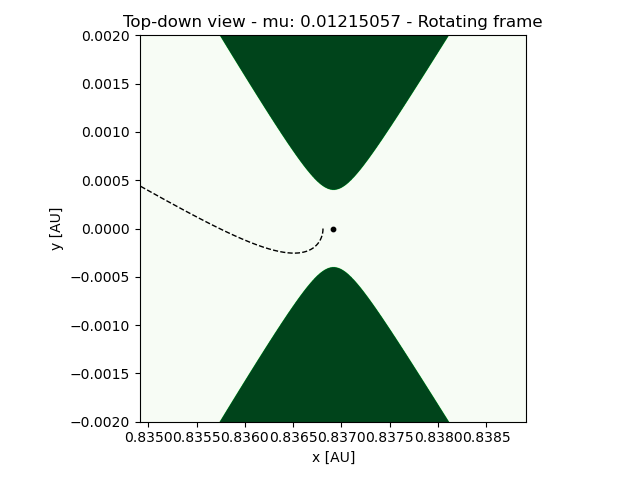

In [30]:
plt.figure()
# s/c trajectory
plt.plot(out[:, 0], out[:, 1], linestyle="--", linewidth=1, c='k')
plt.scatter(out[-1, 0], out[-1, 1], s=5)

# masses
plt.scatter(-mu, 0, c="r", s=20)  # m1
plt.scatter(1 - mu, 0, c="r", s=20)  # m2

# Lagrange points
plt.scatter(xL1, 0, c="k", s=10)  # m2
plt.scatter(xL2, 0, c="k", s=10)  # m2
plt.scatter(xL3, 0, c="k", s=10)  # m2
plt.scatter(xL4, yL4, c="k", s=10)  # m2
plt.scatter(xL5, yL5, c="k", s=10)  # m2

# zero velocity curve
plt.imshow((potentials >= E).astype(int),
    extent=(x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()),
    origin="lower",
    cmap="Greens"
    )

plt.title(f"Top-down view - mu: {mu} - Rotating frame")
plt.xlabel("x [AU]")
plt.ylabel("y [AU]")
plt.xlim([xL1 - buffer, xL1 + buffer])
plt.ylim([0.0 - buffer, 0.0 + buffer])
# plt.xlim([-1.5, 1.5])
# plt.ylim([-1.5, 1.5])
plt.tight_layout()

plt.show()

In [31]:
E

-1.6001716248715736

In [32]:
def corrector(ta, x0):
    """
    Performs and logs a step of a corrector algorithm that takes a numerical integration from x0 -> T -> xf. The result
    is a new tentative x0 that should result in a closed orbit.
    """
    x0 = np.array(x0)
    mu = ta.pars[0]
    t_final = ta.time
    
    state_T = ta.state[:6]
    
    Phi = ta.state[6:].reshape((6,6))
    H = get_cr3bp_hamiltonian(mu=mu, state=state_T, conj_mom=True)
    dynT = get_hamiltonian_state_derivative(H, state=state_T, conj_mom=True).reshape((-1, 1))
    # dynT = dyn_cf(state_T, pars=[mu]).reshape((-1,1))

    # We add as last state delta T
    A = np.concatenate((Phi - np.eye(6), dynT), axis=1)
    # We add the Poincare phasing condition as a last equation
    phasing_cond = np.insert(dynT, -1, 0).reshape((1,-1))

    A = np.concatenate((A, phasing_cond))
    # We construct the r.h.s.
    b = (x0 - state_T).reshape(-1,1)
    print("error was:", np.linalg.norm(b))
    # need to add the zero corresponding to the phasing condition
    b = np.insert(b, -1, 0)
    
    delta = np.linalg.inv(A)@b
    print("condition number is:", np.linalg.cond(A))
    
    x0_new = x0 + delta[:6]
    t_final = t_final + delta[-1]

    # Reset the state
    ta.time = 0.
    ta.state[:] = x0_new.reshape((-1,)).tolist() + np.eye(6).reshape((36,)).tolist()
    # Go ...
    ta.propagate_until(t_final)
    # New error is:
    b = (x0_new - ta.state[:6]).reshape(-1,1)
    print("new error is:", np.linalg.norm(b))
    return ta, x0_new.tolist()

In [33]:
ic_periodic = init_cond
for i in range(6):
    ta, ic_periodic = corrector(ta, ic_periodic)

error was: 2.1495510474828126


LinAlgError: Singular matrix